# AWS Elastic Kubernetes Service (EKS) Deep MNIST
In this example we will deploy a tensorflow MNIST model in Amazon Web Services' Elastic Kubernetes Service (EKS).

This tutorial will break down in the following sections:

1) Train a tensorflow model to predict mnist locally

2) Containerise the tensorflow model with our docker utility

3) Send some data to the docker model to test it

4) Install and configure AWS tools to interact with AWS

5) Use the AWS tools to create and setup EKS cluster with Seldon

6) Push and run docker image through the AWS Container Registry

7) Test our Elastic Kubernetes deployment by sending some data

#### Let's get started! 🚀🔥

## Dependencies:

* Helm v2.13.1+
* A Kubernetes cluster running v1.13 or above (minkube / docker-for-windows work well if enough RAM)
* kubectl v1.14+
* EKS CLI v0.1.32
* AWS Cli v1.16.163
* Python 3.6+
* Python DEV requirements


## 1) Train a tensorflow model to predict mnist locally
We will load the mnist images, together with their labels, and then train a tensorflow model to predict the right labels

In [16]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
import tensorflow as tf

if __name__ == '__main__':
    
    x = tf.placeholder(tf.float32, [None,784], name="x")

    W = tf.Variable(tf.zeros([784,10]))
    b = tf.Variable(tf.zeros([10]))

    y = tf.nn.softmax(tf.matmul(x,W) + b, name="y")

    y_ = tf.placeholder(tf.float32, [None, 10])

    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

    init = tf.initialize_all_variables()

    sess = tf.Session()
    sess.run(init)

    for i in range(1000):
        batch_xs, batch_ys = mnist.train.next_batch(100)
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(sess.run(accuracy, feed_dict = {x: mnist.test.images, y_:mnist.test.labels}))

    saver = tf.train.Saver()

    saver.save(sess, "model/deep_mnist_model")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0.9189


## 2) Containerise the tensorflow model with our docker utility

First you need to make sure that you have added the .s2i/environment configuration file in this folder with the following content:

In [2]:
!cat .s2i/environment

MODEL_NAME=DeepMnist
API_TYPE=REST
SERVICE_TYPE=MODEL
PERSISTENCE=0


Now we can build a docker image named "deep-mnist" with the tag 0.1

In [20]:
!s2i build . seldonio/seldon-core-s2i-python36:0.13 deep-mnist:0.1

---> Installing application source...
---> Installing dependencies ...
Looking in links: /whl
Stored in directory: /root/.cache/pip/wheels/d7/de/2e/efa132238792efb6459a96e85916ef8597fcb3d2ae51590dfd
Stored in directory: /root/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
Stored in directory: /root/.cache/pip/wheels/59/38/c6/234dc39b4f6951a0768fbc02d5b7207137a5b1d9094f0d54bf
Stored in directory: /root/.cache/pip/wheels/a7/15/a0/0a0561549ad11cdc1bc8fa1191a353efd30facf6bfb507aefc
Successfully built wrapt termcolor gast absl-py
You should consider upgrading via the 'pip install --upgrade pip' command.
Build completed successfully


## 3) Send some data to the docker model to test it
We first run the docker image we just created as a container called "mnist_predictor"

In [22]:
!docker run --name "mnist_predictor" -d --rm -p 5000:5000 deep-mnist:0.1

eaf2be140dae7350fc096c1f313e8322567b6763458a60742bbeb169709a3aec


Send some random features that conform to the contract

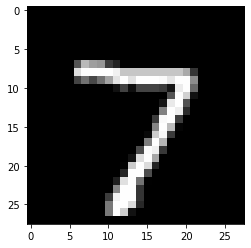

Expected label:  7.0 . One hot encoding:  [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [6]:
import matplotlib.pyplot as plt
import numpy as np
# This is the variable that was initialised at the beginning of the file
i = [0]
x = mnist.test.images[i]
y = mnist.test.labels[i]
plt.imshow(x.reshape((28, 28)), cmap='gray')
plt.show()
print("Expected label: ", np.sum(range(0,10) * y), ". One hot encoding: ", y)

In [23]:
from seldon_core.seldon_client import SeldonClient
import math
import numpy as np

# We now test the REST endpoint expecting the same result
endpoint = "0.0.0.0:5000"
batch = x
payload_type = "ndarray"

sc = SeldonClient(microservice_endpoint=endpoint)

# We use the microservice, instead of the "predict" function
client_prediction = sc.microservice(
    data=batch,
    method="predict",
    payload_type=payload_type,
    names=["tfidf"])

for proba, label in zip(client_prediction.response.data.ndarray.values[0].list_value.ListFields()[0][1], range(0,10)):
    print(f"LABEL {label}:\t {proba.number_value*100:6.4f} %")

SeldonClientException: 

In [25]:
!docker rm mnist_predictor --force

mnist_predictor_2


## 4) Install and configure AWS tools to interact with AWS

First we install the awscli

In [8]:
!pip install awscli --upgrade --user

  Using cached https://files.pythonhosted.org/packages/f6/45/259a98719e7c7defc9be4cc00fbfb7ccf699fbd1f74455d8347d0ab0a1df/awscli-1.16.163-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/db/c8/7dcf9dbcb22429512708fe3a547f8b6101c0d02137acbd892505aee57adf/colorama-0.3.9-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ec/3b/029218966ce62ae9824a18730de862ac8fc5a0e8083d07d1379815e7cca1/botocore-1.12.153-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e1/ae/baedc9cb175552e95f3395c43055a6a5e125ae4d48a1d7a924baca83e92e/rsa-3.4.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7b/7c/c9386b82a25115cccf1903441bba3cbadcfae7b678a20167347fa8ded34c/pyasn1-0.4.5-py2.py3-none-any.whl


#### Configure aws so it can talk to your server 
(if you are getting issues, make sure you have the permmissions to create clusters)

In [20]:
%%bash 
# You must make sure that the access key and secret are changed
aws configure << END_OF_INPUTS
YOUR_ACCESS_KEY
YOUR_ACCESS_SECRET
us-west-2
json
END_OF_INPUTS

AWS Access Key ID [****************SF4A]: AWS Secret Access Key [****************WLHu]: Default region name [eu-west-1]: Default output format [json]: 

#### Install EKCTL
*IMPORTANT*: These instructions are for linux
Please follow the official installation of ekctl at: https://docs.aws.amazon.com/eks/latest/userguide/getting-started-eksctl.html

In [23]:
!curl --silent --location "https://github.com/weaveworks/eksctl/releases/download/latest_release/eksctl_$(uname -s)_amd64.tar.gz" | tar xz 

In [25]:
!chmod 755 ./eksctl

In [27]:
!./eksctl version

[ℹ]  version.Info{BuiltAt:"", GitCommit:"", GitTag:"0.1.32"}


## 5) Use the AWS tools to create and setup EKS cluster with Seldon
In this example we will create a cluster with 2 nodes, with a minimum of 1 and a max of 3. You can tweak this accordingly.

If you want to check the status of the deployment you can go to AWS CloudFormation or to the EKS dashboard.

It will take 10-15 minutes (so feel free to go grab a ☕). 

### IMPORTANT: If you get errors in this step...
It is most probably IAM role access requirements, which requires you to discuss with your administrator.

In [107]:
%%bash
./eksctl create cluster \
--name demo-eks-cluster \
--region us-west-2 \
--nodes 2 

Process is interrupted.


### Configure local kubectl 
We want to now configure our local Kubectl so we can actually reach the cluster we've just created

In [108]:
! aws eks --region us-west-2 update-kubeconfig --name demo-eks-cluster

Updated context arn:aws:eks:eu-west-1:271049282727:cluster/deepmnist in /home/alejandro/.kube/config


And we can check if the context has been added to kubectl config (contexts are basically the different k8s cluster connections)
You should be able to see the context as "...aws:eks:eu-west-1:27...". 
If it's not activated you can activate that context with kubectlt config set-context <CONTEXT_NAME>

In [109]:
!kubectl config get-contexts

CURRENT   NAME                                                   CLUSTER                                                AUTHINFO                                               NAMESPACE
*         arn:aws:eks:eu-west-1:271049282727:cluster/deepmnist   arn:aws:eks:eu-west-1:271049282727:cluster/deepmnist   arn:aws:eks:eu-west-1:271049282727:cluster/deepmnist   
          docker-desktop                                         docker-desktop                                         docker-desktop                                         
          docker-for-desktop                                     docker-desktop                                         docker-desktop                                         
          gke_ml-engineer_us-central1-a_security-cluster-1       gke_ml-engineer_us-central1-a_security-cluster-1       gke_ml-engineer_us-central1-a_security-cluster-1       


## Install Seldon Core

### Before we install seldon core, we need to install HELM
For that, we need to create a ClusterRoleBinding for us, a ServiceAccount, and then a RoleBinding

In [4]:
!kubectl create clusterrolebinding kube-system-cluster-admin --clusterrole=cluster-admin --serviceaccount=kube-system:default

clusterrolebinding.rbac.authorization.k8s.io/kube-system-cluster-admin created


In [5]:
!kubectl create serviceaccount tiller --namespace kube-system

serviceaccount/tiller created


In [6]:
!kubectl apply -f tiller-role-binding.yaml

clusterrolebinding.rbac.authorization.k8s.io/tiller-role-binding created


### Once that is set-up we can install Tiller

In [7]:
!helm init --service-account tiller

$HELM_HOME has been configured at /home/joel/.helm.

Tiller (the Helm server-side component) has been installed into your Kubernetes Cluster.

Please note: by default, Tiller is deployed with an insecure 'allow unauthenticated users' policy.
To prevent this, run `helm init` with the --tiller-tls-verify flag.
For more information on securing your installation see: https://docs.helm.sh/using_helm/#securing-your-helm-installation


In [8]:
# Wait until Tiller finishes
!kubectl rollout status deploy/tiller-deploy -n kube-system

Waiting for deployment "tiller-deploy" rollout to finish: 0 of 1 updated replicas are available...
deployment "tiller-deploy" successfully rolled out


### Now we can install SELDON. 
We first start with the custom resource definitions (CRDs)

In [1]:
!helm install seldon-core-operator --name seldon-core-operator --repo https://storage.googleapis.com/seldon-charts --set usageMetrics.enabled=true   --namespace seldon-system

NAME:   seldon-core-operator
LAST DEPLOYED: Wed May 22 16:24:10 2019
NAMESPACE: seldon-system
STATUS: DEPLOYED

RESOURCES:
==> v1/ClusterRole
NAME                          AGE
seldon-operator-manager-role  2s

==> v1/ClusterRoleBinding
NAME                                 AGE
seldon-operator-manager-rolebinding  2s

==> v1/ConfigMap
NAME                     DATA  AGE
seldon-spartakus-config  3     2s

==> v1/Pod(related)
NAME                                         READY  STATUS             RESTARTS  AGE
seldon-operator-controller-manager-0         0/1    ContainerCreating  0         2s
seldon-spartakus-volunteer-6954cffb89-qz4pq  0/1    ContainerCreating  0         1s

==> v1/Secret
NAME                                   TYPE    DATA  AGE
seldon-operator-webhook-server-secret  Opaque  0     2s

==> v1/Service
NAME                                        TYPE       CLUSTER-IP      EXTERNAL-IP  PORT(S)  AGE
seldon-operator-controller-manager-service  ClusterIP  10.100.198.157  <none>    

And confirm they are running by getting the pods:

In [3]:
!kubectl rollout status deploy/seldon-controller-manager -n seldon-system

partitioned roll out complete: 1 new pods have been updated...


### Now we set-up the ingress
This will allow you to reach the Seldon models from outside the kubernetes cluster. 

In EKS it automatically creates an Elastic Load Balancer, which you can configure from the EC2 Console

In [4]:
!helm install stable/ambassador --name ambassador --set crds.keep=false

NAME:   ambassador
LAST DEPLOYED: Wed May 22 16:25:38 2019
NAMESPACE: default
STATUS: DEPLOYED

RESOURCES:
==> v1/Deployment
NAME        READY  UP-TO-DATE  AVAILABLE  AGE
ambassador  0/3    3           0          0s

==> v1/Pod(related)
NAME                         READY  STATUS             RESTARTS  AGE
ambassador-6dbf99c886-frlfm  0/1    ContainerCreating  0         0s
ambassador-6dbf99c886-kj56r  0/1    ContainerCreating  0         0s
ambassador-6dbf99c886-v5mtv  0/1    ContainerCreating  0         0s

==> v1/Service
NAME               TYPE          CLUSTER-IP      EXTERNAL-IP  PORT(S)                     AGE
ambassador         LoadBalancer  10.100.59.146   <pending>    80:30911/TCP,443:31715/TCP  0s
ambassador-admins  ClusterIP     10.100.152.178  <none>       8877/TCP                    0s

==> v1/ServiceAccount
NAME        SECRETS  AGE
ambassador  1        0s

==> v1beta1/ClusterRole
NAME        AGE
ambassador  0s

==> v1beta1/ClusterRoleBinding
NAME        AGE
ambassador  0s


N

And let's wait until it's fully deployed

In [ ]:
!kubectl rollout status deployment.apps/ambassador

## Push docker image
In order for the EKS seldon deployment to access the image we just built, we need to push it to the Elastic Container Registry (ECR).

If you have any issues please follow the official AWS documentation: https://docs.aws.amazon.com/AmazonECR/latest/userguide/docker-basics.html

### First we create a registry
You can run the following command, and then see the result at https://us-west-2.console.aws.amazon.com/ecr/repositories?#

In [12]:
!aws ecr create-repository --repository-name seldon-repository --region us-west-2

{
    "repository": {
        "repositoryArn": "arn:aws:ecr:eu-west-2:271049282727:repository/seldon-repository",
        "registryId": "271049282727",
        "repositoryName": "seldon-repository",
        "repositoryUri": "271049282727.dkr.ecr.eu-west-2.amazonaws.com/seldon-repository",
        "createdAt": 1574613481.0,
        "imageTagMutability": "MUTABLE",
        "imageScanningConfiguration": {
            "scanOnPush": false
        }
    }
}


### Now prepare docker image
We need to first tag the docker image before we can push it

In [26]:
%%bash
export AWS_ACCOUNT_ID="271049282727"
export AWS_REGION="us-west-2"
if [ -z "$AWS_ACCOUNT_ID" ]; then
    echo "ERROR: Please provide a value for the AWS variables"
    exit 1
fi

docker tag deep-mnist:0.1 "$AWS_ACCOUNT_ID.dkr.ecr.$AWS_REGION.amazonaws.com/seldon-repository"

### We now login to aws through docker so we can access the repository

In [10]:
!`aws ecr get-login --no-include-email --region us-west-2`

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/joel/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


### And push the image
Make sure you add your AWS Account ID

In [27]:
%%bash
export AWS_ACCOUNT_ID="271049282727"
export AWS_REGION="us-west-2"
if [ -z "$AWS_ACCOUNT_ID" ]; then
    echo "ERROR: Please provide a value for the AWS variables"
    exit 1
fi

docker push "$AWS_ACCOUNT_ID.dkr.ecr.$AWS_REGION.amazonaws.com/seldon-repository"

The push refers to repository [271049282727.dkr.ecr.us-west-2.amazonaws.com/seldon-repository]
c76ed05a0fbd: Preparing
a195aef6aae5: Preparing
a4869ba7b14b: Preparing
d88f9b4076eb: Preparing
41a614c54909: Preparing
5d5d86989c42: Preparing
8296c34d0641: Preparing
4d29b148a147: Preparing
bd5afbfde642: Preparing
0fe19df8b8f8: Preparing
b17cc31e431b: Preparing
12cb127eee44: Preparing
604829a174eb: Preparing
fbb641a8b943: Preparing
8296c34d0641: Waiting
4d29b148a147: Waiting
bd5afbfde642: Waiting
12cb127eee44: Waiting
b17cc31e431b: Waiting
604829a174eb: Waiting
fbb641a8b943: Waiting
0fe19df8b8f8: Waiting
a4869ba7b14b: Layer already exists
d88f9b4076eb: Layer already exists
a195aef6aae5: Layer already exists
41a614c54909: Layer already exists
4d29b148a147: Layer already exists
bd5afbfde642: Layer already exists
5d5d86989c42: Layer already exists
8296c34d0641: Layer already exists
12cb127eee44: Layer already exists
604829a174eb: Layer already exists
0fe19df8b8f8: Layer already exists
b17cc31e

## Running the Model
We will now run the model.

Let's first have a look at the file we'll be using to trigger the model:

In [15]:
!cat deep_mnist.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
        "labels": {
            "app": "seldon"
        },
        "name": "deep-mnist"
    },
    "spec": {
        "annotations": {
            "project_name": "Tensorflow MNIST",
            "deployment_version": "v1"
        },
        "name": "deep-mnist",
        "oauth_key": "oauth-key",
        "oauth_secret": "oauth-secret",
        "predictors": [
            {
                "componentSpecs": [{
                    "spec": {
                        "containers": [
                            {
                                "image": "271049282727.dkr.ecr.us-west-2.amazonaws.com/seldon-repository:latest",
                                "imagePullPolicy": "IfNotPresent",
                                "name": "classifier",
                                "resources": {
                                    "requests": {
                                        "memory":

Now let's trigger seldon to run the model.

We basically have a yaml file, where we want to replace the value "REPLACE_FOR_IMAGE_AND_TAG" for the image you pushed

In [165]:
%%bash
export AWS_ACCOUNT_ID=""
export AWS_REGION="us-west-2"
if [ -z "$AWS_ACCOUNT_ID" ]; then
    echo "ERROR: Please provide a value for the AWS variables"
    exit 1
fi

sed 's|REPLACE_FOR_IMAGE_AND_TAG|'"$AWS_ACCOUNT_ID"'.dkr.ecr.'"$AWS_REGION"'.amazonaws.com/seldon-repository|g' deep_mnist.json | kubectl apply -f -

error: unable to recognize "STDIN": Get https://461835FD3FF52848655C8F09FBF5EEAA.yl4.us-west-2.eks.amazonaws.com/api?timeout=32s: dial tcp: lookup 461835FD3FF52848655C8F09FBF5EEAA.yl4.us-west-2.eks.amazonaws.com on 1.1.1.1:53: no such host


CalledProcessError: Command 'b'export AWS_ACCOUNT_ID="2710"\nexport AWS_REGION="us-west-2"\nif [ -z "$AWS_ACCOUNT_ID" ]; then\n    echo "ERROR: Please provide a value for the AWS variables"\n    exit 1\nfi\n\nsed \'s|REPLACE_FOR_IMAGE_AND_TAG|\'"$AWS_ACCOUNT_ID"\'.dkr.ecr.\'"$AWS_REGION"\'.amazonaws.com/seldon-repository|g\' deep_mnist.json | kubectl apply -f -\n'' returned non-zero exit status 1.

And let's check that it's been created.

You should see an image called "deep-mnist-single-model...".

We'll wait until STATUS changes from "ContainerCreating" to "Running"

In [20]:
!kubectl get pods

NAME                                              READY   STATUS    RESTARTS   AGE
ambassador-5475779f98-7bhcw                       1/1     Running   0          21m
ambassador-5475779f98-986g5                       1/1     Running   0          21m
ambassador-5475779f98-zcd28                       1/1     Running   0          21m
deep-mnist-single-model-42ed9d9-fdb557d6b-6xv2h   2/2     Running   0          18m


## Test the model
Now we can test the model, let's first find out what is the URL that we'll have to use:

In [46]:
!kubectl get svc ambassador -o jsonpath='{.status.loadBalancer.ingress[0].hostname}' 

ab07a788012a111eaa042125f55a39fa-1430468363.us-east-1.elb.amazonaws.com

We'll use a random example from our dataset

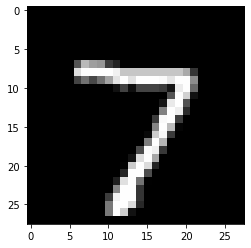

Expected label:  7.0 . One hot encoding:  [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [35]:
import matplotlib.pyplot as plt
# This is the variable that was initialised at the beginning of the file
i = [0]
x = mnist.test.images[i]
y = mnist.test.labels[i]
plt.imshow(x.reshape((28, 28)), cmap='gray')
plt.show()
print("Expected label: ", np.sum(range(0,10) * y), ". One hot encoding: ", y)

We can now add the URL above to send our request:

In [47]:
from seldon_core.seldon_client import SeldonClient
import math
import numpy as np

host = "ab07a788012a111eaa042125f55a39fa-1430468363.us-east-1.elb.amazonaws.com"
port = "80" # Make sure you use the port above
batch = x
payload_type = "ndarray"

sc = SeldonClient(
    gateway="ambassador", 
    gateway_endpoint=host + ":" + port,
    namespace="default",
    oauth_key="oauth-key", 
    oauth_secret="oauth-secret")

client_prediction = sc.predict(
    data=batch, 
    deployment_name="deep-mnist",
    names=["text"],
    payload_type=payload_type)

print(client_prediction)

Success:True message:
Request:
data {
  names: "text"
  ndarray {
    values {
      list_value {
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
     

### Let's visualise the probability for each label
It seems that it correctly predicted the number 7

In [48]:
for proba, label in zip(client_prediction.response.data.ndarray.values[0].list_value.ListFields()[0][1], range(0,10)):
    print(f"LABEL {label}:\t {proba.number_value*100:6.4f} %")

LABEL 0:	 10.0000 %
LABEL 1:	 10.0000 %
LABEL 2:	 10.0000 %
LABEL 3:	 10.0000 %
LABEL 4:	 10.0000 %
LABEL 5:	 10.0000 %
LABEL 6:	 10.0000 %
LABEL 7:	 10.0000 %
LABEL 8:	 10.0000 %
LABEL 9:	 10.0000 %
